# Lesson 4 Assignment - Autodetection of Breast Cancer

## Author - Kenji Oman

### Background
The <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">Breast Cancer Wisconsin (Diagnostic) Data set</a> contains donated data.
These data were obtained from the University of Wisconsin Hospitals, Madison. Donors:
1. Dr. William H. Wolberg, General Surgery Dept.
2. W. Nick Street, Computer Sciences Dept.
3. Olvi L. Mangasarian, Computer Sciences Dept.

They contain the simplified and normalized attributes used to detect breast cancer. Your task is to build
a decision tree classifier that would be able to detect, based on the attributes below, whether a tumor is
benign or malignant.

Attributes:
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitosis
11. Class (4 for malignant, 2 for benign)




## Tasks
Using the provided WI_Breast_Cancer.csv file, build an experiment using a decision tree.

Answer the following questions:
1. Test both entropy and the gini coefficient. Which performs better and why?
2. What are the best hyperparameter settings for both?
3. Visualize both models and see which feature is selected for each criterion. Are they same for
both? Why or why not?
4. Determine the AUC for the best model you can achieve. What are the precision and recall values
and which might be the one you want to maximize?
5. What are the implications of using this type of machine learning algorithm for breast cancer
analysis?


In [1]:
URL = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/WI_Breast_Cancer.csv"
colnames = ['Sample_code' , 'Class', 'Clump_thick', 'Uni_cell_sz', 'Uni_cell_shp', 'Marg_adhes', 
             'Single_cell_sz', 'Bare_Nucl', 'Bland_Chr', 'Norm_Nucl', 'Mitosis']

In [2]:
# Import libraries
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import tree
import sklearn.metrics as sklm
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from IPython.display import display, Markdown, Image

%matplotlib inline

# Data Peek/ EDA

In [3]:
# First, read the data, then peek at it
df = pd.read_csv(URL, header=None, names=colnames)
df.head()

,Sample_code,Class,Clump_thick,Uni_cell_sz,Uni_cell_shp,Marg_adhes,Single_cell_sz,Bare_Nucl,Bland_Chr,Norm_Nucl,Mitosis
0,1000025,2,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1
1,1002945,2,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1
2,1015425,2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1
3,1016277,2,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1
4,1017023,2,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1


In [4]:
# Get some basic stats on the data
display(df.info())
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 11 columns):
Sample_code       709 non-null object
Class             702 non-null object
Clump_thick       702 non-null float64
Uni_cell_sz       701 non-null float64
Uni_cell_shp      701 non-null float64
Marg_adhes        701 non-null float64
Single_cell_sz    701 non-null float64
Bare_Nucl         701 non-null float64
Bland_Chr         701 non-null float64
Norm_Nucl         701 non-null float64
Mitosis           701 non-null object
dtypes: float64(8), object(3)
memory usage: 61.0+ KB


None

,Sample_code,Class,Clump_thick,Uni_cell_sz,Uni_cell_shp,Marg_adhes,Single_cell_sz,Bare_Nucl,Bland_Chr,Norm_Nucl,Mitosis
count,709,702,702.000000,701.000000,701.00000,701.000000,701.000000,701.000000,701.000000,701.000000,701
unique,654,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
top,1182404,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
freq,6,458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,579
mean,NaN,NaN,7.263533,3.154066,3.21826,2.813124,3.226819,3.456491,3.447932,2.877318,NaN
std,NaN,NaN,75.031332,3.069053,2.97456,2.858201,2.220340,3.637881,2.447550,3.061150,NaN
min,NaN,NaN,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,NaN
25%,NaN,NaN,2.000000,1.000000,1.00000,1.000000,2.000000,1.000000,2.000000,1.000000,NaN
50%,NaN,NaN,4.000000,1.000000,1.00000,1.000000,2.000000,1.000000,3.000000,1.000000,NaN
75%,NaN,NaN,6.000000,5.000000,5.00000,4.000000,4.000000,5.000000,5.000000,4.000000,NaN


In [5]:
# It looks like most of the columns are ordinal, going from either zero or one to ten.
# Let's take a look at  the unique values of Mitosis, and also those rows with NaN
display(df.Mitosis.unique())
df[df.isna().any(axis=1)]

array(['1', '5', '4', '2', '3', '7', '10', '8', '6', nan,
       '3) <-----Reappears in Group 8 as:', '3 '], dtype=object)

,Sample_code,Class,Clump_thick,Uni_cell_sz,Uni_cell_shp,Marg_adhes,Single_cell_sz,Bare_Nucl,Bland_Chr,Norm_Nucl,Mitosis
367,##### Group 2 : 70 points: 57B 13M (October 1989),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438,##### Group 3 : 31 points: 22B 9M (February 1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,##### Group 4 : 17 points: 14B 3M (April 1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,##### Group 5 : 48 points: 36B 12M (August 1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,##### Group 6: 49 Points: 40B 9M (December 7,1990; Updated Jan 8,1991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,##### by dropping 2 unsatisfactorily measure...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,##### Group 7: 31 Points: 16B 15M (June 1991),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
622,##### Group 8: 86 Points: 72B 14M (November ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above, we see that we have some comment lines.  Confimed by looking in the file, where we find things such as:
```
.
.
.
896404,2,2,1,1,1,2,1,3,1,1
897172,2,2,1,1,1,2,1,2,1,1
95719,4,6,10,10,10,8,10,7,10,7

##### Group 2 : 70 points: 57B 13M (October 1989)

160296,4,5,8,8,10,5,10,8,10,3
342245,2,1,1,3,1,2,1,1,1,1
.
.
.
```
or,
```
.
.
.
867392,2,4,2,2,1,2,1,2,1,1
869828,2,1,1,1,1,1,1,3,1,1

##### Group 6: 49 Points: 40B  9M (December 7, 1990; Updated Jan 8, 1991
##### by dropping 2 unsatisfactorily   measured points 803531 &
##### 1268952,4,10,10,7,2,7,1,4,3,3) <-----Reappears in Group 8 as:
##### 1268952,4,10,10,7,8,7,1,10,10,3 

1043068,2,3,1,1,1,2,1,2,1,1
1056171,2,2,1,1,1,2,1,2,1,1
.
.
.
```

The easiest solution to this is to re-import the file, this time specifying comment characters whose lines should be ignored.

In [6]:
# Re-ingest the file, this time ignoring comment lines.
df = pd.read_csv(URL, header=None, names=colnames, comment='#')
df[df.isna().any(axis=1)]

,Sample_code,Class,Clump_thick,Uni_cell_sz,Uni_cell_shp,Marg_adhes,Single_cell_sz,Bare_Nucl,Bland_Chr,Norm_Nucl,Mitosis


In [7]:
# Now, we don't have any missing values!  Taking a look at the descriptive statistics again
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Sample_code       699 non-null int64
Class             699 non-null int64
Clump_thick       699 non-null int64
Uni_cell_sz       699 non-null int64
Uni_cell_shp      699 non-null int64
Marg_adhes        699 non-null int64
Single_cell_sz    699 non-null int64
Bare_Nucl         699 non-null int64
Bland_Chr         699 non-null int64
Norm_Nucl         699 non-null int64
Mitosis           699 non-null int64
dtypes: int64(11)
memory usage: 60.1 KB


None

,Sample_code,Class,Clump_thick,Uni_cell_sz,Uni_cell_shp,Marg_adhes,Single_cell_sz,Bare_Nucl,Bland_Chr,Norm_Nucl,Mitosis
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,2.689557,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413
std,6.170957e+05,0.951273,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078
min,6.163400e+04,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,8.706885e+05,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,1.171710e+06,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,1.238298e+06,4.000000,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000
max,1.345435e+07,4.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


So, we find that we have int's for all our columns, and most range from 1-10, with thte exception of Bare_Nucl, which ranges from 0-10 (as we mentioned before).  Also, we can drop the Sample_code, as this is a unique ID of the sample, but for our purposes, doesn't serve a purpose.

In [8]:
# Let's drop the sample_code column
df.drop(columns='Sample_code', inplace=True, errors='ignore')

In [9]:
# Let's check for class imbalance
df.Class.value_counts()

2    458
4    241
Name: Class, dtype: int64

It looks like we have some moderate class imbalance, with only 241/(241+458) = 34% of the data being "positive", meaning malignant.  To be sure we are doing the right thing (not over-representing the benign class), let's do a stratified Kfold cross validation for our tests.

# Decision Tree Classifier
## Gini vs Entropy
Let's compare running a decision tree classifier, using both the gini and the entropy criterion to compare the two

In [10]:
# Since sklearn doesn't define a specificity function (TN/(TN + FP)),
# let's define one here. We also care about specificity, but that also
# goes by recall, which is implemented in sklearn
def get_specificity(y, y_pred, **kwargs):
    # Because a confusion matrix takes whatever lable first appeared in
    # the true y values as the "positive" result, we need to sort
    # our y and y_pred's together first, to make sure the "4"s appear
    # before the 2's
    #p = np.argsort(y)
    p = y.reset_index(drop=True).sort_values(ascending=False).index.values
    #sorted_y = y[p[::-1]]
    sorted_y = y.iloc[p].values
    #sorted_y_pred = y_pred[p[::-1]]
    sorted_y_pred = y_pred[p]
    #print(y.values[:5], sorted_y[:5], y_pred[:5], sorted_y_pred[:5])
    # Now, run the confusion matrix
    tn, fp, fn, tp = sklm.confusion_matrix(sorted_y.astype(int), sorted_y_pred.astype(int)).ravel()
    #print (tn, fp, fn, tp)
    return (tn / (tn + fp))

# Now, define the ROC AUC scorer, since the default function only works
# if we have 0/1 as our class labels
def get_auc(y_true, y_score, **kwargs):
    # Note, the y_scores passed will have shape (n_row, 2),
    # since it thinks this is a multi-classification problem,
    # since our target variables are 2, 4 instead of 0, 1.
    # Fix this by grabbing the scores given for the 4 class
    fpr, tpr, _ = sklm.roc_curve(y_true, y_score[:,1], **kwargs)
    return sklm.auc(fpr, tpr)

# Also, let's define our scoring, for use in several places
scoring = {'accuracy': sklm.make_scorer(sklm.accuracy_score),
           'precision': sklm.make_scorer(sklm.precision_score, pos_label=4),
           'sensitivity': sklm.make_scorer(sklm.recall_score, pos_label=4),
           'specificity': sklm.make_scorer(get_specificity),
           'auc': sklm.make_scorer(get_auc, pos_label=4, needs_proba=True)}

In [11]:
# Define a function to do our tests, allowing for classifier hyperparameters to
# be set. Will automatically run using both a entropy and gini based decision tree.
# Performs k-fold cross validation to provide the scores of interest.
def run_tests(**kwargs):
    # Define both a decision tree based on entropy, and on the gini score
    # Random-state = 0 is to make this function reproducible
    entropy_clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=0, **kwargs)
    gini_clf = tree.DecisionTreeClassifier(criterion='gini', random_state=0, **kwargs)
    
    # Now set up our cross-validation
    kfold = StratifiedKFold(n_splits=5, random_state=10)
    cv_params = {
        'X': df.drop(columns='Class'),
        #'X': df.drop(columns='Class').values,
        'y': df.Class,
        #'y': df.Class.values,
        'scoring': scoring,
        'cv': kfold,
        'n_jobs': 1, # found it's actually slower to use multiple cores, since the dataset is small enough
        'return_train_score': False
    }
    entropy_scores = cross_validate(entropy_clf, **cv_params)
    gini_scores = cross_validate(gini_clf, **cv_params)
    
    # Output the average precision, recall (sensitivity), specificity,
    # and auc across the runs fo the cross validation
    display(Markdown('### Gini Metrics'))
    print('Average Accuracy: {:.2f} %'.format(np.mean(gini_scores['test_accuracy'])*100))
    print('Average Precision: {:.2f} %'.format(np.mean(gini_scores['test_precision'])*100))
    print('Average Recall (Sensitivity): {:.2f} %'.format(np.mean(gini_scores['test_sensitivity'])*100))
    print('Average Specificity: {:.2f} %'.format(np.mean(gini_scores['test_specificity'])*100))
    print('Average AUC: {:.2f}'.format(np.mean(gini_scores['test_auc'])))
    
    display(Markdown('### Entropy Metrics'))
    print('Average Accuracy: {:.2f} %'.format(np.mean(entropy_scores['test_accuracy'])*100))
    print('Average Precision: {:.2f} %'.format(np.mean(entropy_scores['test_precision'])*100))
    print('Average Recall (Sensitivity): {:.2f} %'.format(np.mean(entropy_scores['test_sensitivity'])*100))
    print('Average Specificity: {:.2f} %'.format(np.mean(entropy_scores['test_specificity'])*100))
    print('Average AUC: {:.2f}'.format(np.mean(entropy_scores['test_auc'])))
    
    display(Markdown('### t-test on metrics'))
    display(Markdown("""**WARNING**: Pick your metric and stick with it, or else you
                        run into multiple testing issues"""))
    print('Accuracy p-val: {:3g}'.format(stats.ttest_ind(gini_scores['test_accuracy'], entropy_scores['test_accuracy'], equal_var=False)[1]))
    print('Precision p-val: {:3g}'.format(stats.ttest_ind(gini_scores['test_precision'], entropy_scores['test_precision'], equal_var=False)[1]))
    print('Recal (Sensitivity) p-val: {:3g}'.format(stats.ttest_ind(gini_scores['test_sensitivity'], entropy_scores['test_sensitivity'], equal_var=False)[1]))
    print('Specificity p-val: {:3g}'.format(stats.ttest_ind(gini_scores['test_specificity'], entropy_scores['test_specificity'], equal_var=False)[1]))
    print('AUC p-val: {:3g}'.format(stats.ttest_ind(gini_scores['test_auc'], entropy_scores['test_auc'], equal_var=False)[1]))

In [12]:
# Now, let's run our tests
run_tests()

### Gini Metrics

Average Accuracy: 94.14 %
Average Precision: 92.79 %
Average Recall (Sensitivity): 90.51 %
Average Specificity: 96.08 %
Average AUC: 0.93


### Entropy Metrics

Average Accuracy: 92.85 %
Average Precision: 91.24 %
Average Recall (Sensitivity): 88.00 %
Average Specificity: 95.42 %
Average AUC: 0.92


### t-test on metrics

**WARNING**: Pick your metric and stick with it, or else you
                        run into multiple testing issues

Accuracy p-val: 0.371503
Precision p-val: 0.580384
Recal (Sensitivity) p-val: 0.630439
Specificity p-val: 0.711937
AUC p-val: 0.468765


### Conclusions: Which performs better, and why?
With default hyperparameters, we see that there is no statistically significant difference between predictions made using the gini criteria vs the entropy criteria, no matter which metric we use, at the $\alpha=0.05$ significnace level (granted, this is based off of 5-fold cross validation -- if we had a lot more data and did a lot more splits, perhaps we would see a statistically significant difference between the two, but probably unlikely considering how similar these two distributions are).

On face value, though, every one of the Gini metrics was higher (better) than those for entropy.  But, to support the fact that neither metric makes much difference, there is a [StackExchange post](https://datascience.stackexchange.com/a/10253) which references [a paper](https://doi.org/10.1023/B:AMAI.0000018580.96245.c6) that concludes there is only a difference in results in about 2% of cases.  The same paper also concludes it is slightly faster to compute the gini index (since entropy requires the calculation of a logarithm), so this would be perhaps the reason why sklearn uses the gini index by default.

However, in class (and on one of the slides), Kristin mentioned that the Gini index tends to be greedier, and classifies the most dominant class on one side of the tree, while entropy is more balanced in splitting the classes equally (Gini makes deeper trees, Entropy makes wider ones).

So, how do we reconcile the two statements?  This seems to be a result of how the Gini index vs Entropy get to their performance metrics -- perhaps Gini focus on one class to get good predictions on the first class, then the next, etc, while entropy tries to improve classification of each class simultaneously, for every layer of the tree.  So, if we constrained how many layers we give our trees, and specifically if we had a multi-class classification problem (more than two outcomes), we might see a difference between the two split criterea (but, I admit, I did not read through the paper referenced above fully, so it is possible that these two methods will achieve similar metrics at every layer of their trees).

## Hyperparameter Tuning
Now, let's see what combinations of Hyper Parameters work the best.  Let's continue to try with both gini and entropy split criteria to compare these for each set of hyperparameters.  We will try a grid serch of the hyperparameters, with the following values:
* max_depth: None, 1:11:1 (in python index notation, 1 - 10, in steps of 1)
* min_samples_split: 2:(N/10 + 1):10
* min_samples_leaf: 1:10:1 + 10:51:5

For what we want to optimize, let's optimize AUC, since this probably will allow us to find the best model that balances sensitivity and specificity.

*Note: I was originally going to include max_features, but I found the models seemed to use more than that many features anyways, so I don't fully understand the usefullness of this parameter*

In [13]:
# First, define a function to do the gridsearch
def run_gridsearch(criteria='gini', **kwargs):
    
    # first, set up the classifier
    clf = tree.DecisionTreeClassifier(criterion=criteria, random_state=0, **kwargs)
    
    # Now set up our grid search
    kfold = StratifiedKFold(n_splits=5, random_state=10)
    gs_params = {
        'scoring': scoring,
        'cv': kfold,
        'n_jobs': -1,
        'param_grid': {
            # Put None at end of max_depth, or else we won't be able to see if there is a value within
            # 1-10 that achieves the max value, as the final output will just report None (no constraints)
            'max_depth': list(range(1,11)) + [None],
            'min_samples_split': range(2, int((df.shape[0]/ 10) + 1), 10),
            # Likewise, 
            'min_samples_leaf': list(range(1, 10, 1)) + list(range(10, 51, 5))},
        'refit': 'auc',
        'iid': False,
        'return_train_score': False
    }
    gs = GridSearchCV(clf, **gs_params)
    
    # Now, fit to our data
    gs.fit(df.drop(columns='Class'), df.Class)
    
    # return the gridsearch object
    return gs

In [14]:
# Now, run it for both gini and entropy
gini_gs = run_gridsearch(criteria='gini')
entropy_gs = run_gridsearch(criteria='entropy')

In [15]:
# Now, output the best parameters
display(Markdown('### Best Gini Hyperparameters and Metrics'))
print('HyperParameters:\n{}'.format(gini_gs.best_params_))
print('\nMetrics:')
temp = pd.DataFrame(gini_gs.cv_results_)
col = [x for x in temp.columns if (x.split('_')[0] == 'mean') and (x.split('_')[1] == 'test')]
print(temp.loc[temp.rank_test_auc == 1, col].iloc[0])
display(Markdown('### Best Entropy Hyperparameters and Metrics'))
print('HyperParameters:\n{}'.format(entropy_gs.best_params_))
print('\nMetrics:')
temp = pd.DataFrame(entropy_gs.cv_results_)
col = [x for x in temp.columns if (x.split('_')[0] == 'mean') and (x.split('_')[1] == 'test')]
print(temp.loc[temp.rank_test_auc == 1, col].iloc[0])

### Best Gini Hyperparameters and Metrics

HyperParameters:
{'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}

Metrics:
mean_test_accuracy       0.935804
mean_test_precision      0.931774
mean_test_sensitivity    0.880357
mean_test_specificity    0.965194
mean_test_auc            0.978535
Name: 693, dtype: float64


### Best Entropy Hyperparameters and Metrics

HyperParameters:
{'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 22}

Metrics:
mean_test_accuracy       0.928610
mean_test_precision      0.910950
mean_test_sensitivity    0.884524
mean_test_specificity    0.952078
mean_test_auc            0.980599
Name: 695, dtype: float64


It looks like entropy required that there be a larger minimum number of samples within a node to allow splitting (22 vs 2), which prevents nodes from splitting too finely, but both split criteria produced the same max depth of their trees, and the same minimum number of samples in a leaf.  Interestingly, gini performed better in all metrics except for the AUC and the sensitivity.  With the higher AUC, I believe we have more flexibility in further tuning the entropy model to find the right balance between sensitivity and specificity that we'd want.

## Visualize Best Models
Let's take a look at what the decision trees look like based on these best models generated.

### Best Gini Tree

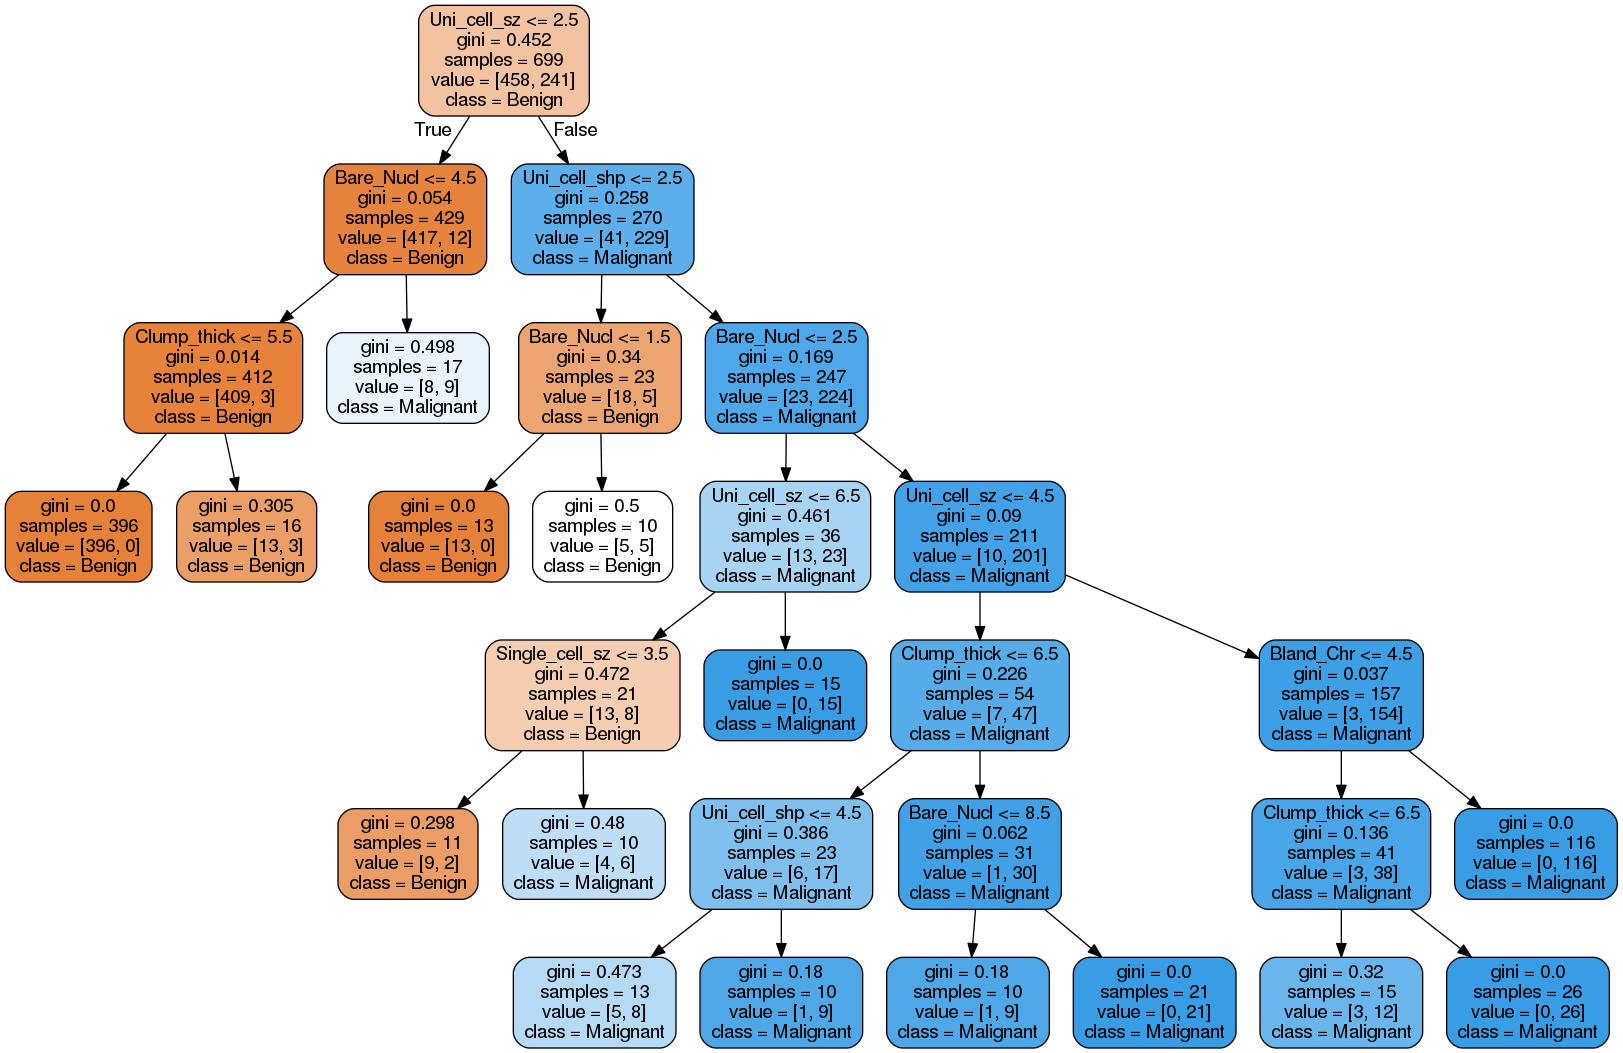

### Best Entropy Tree

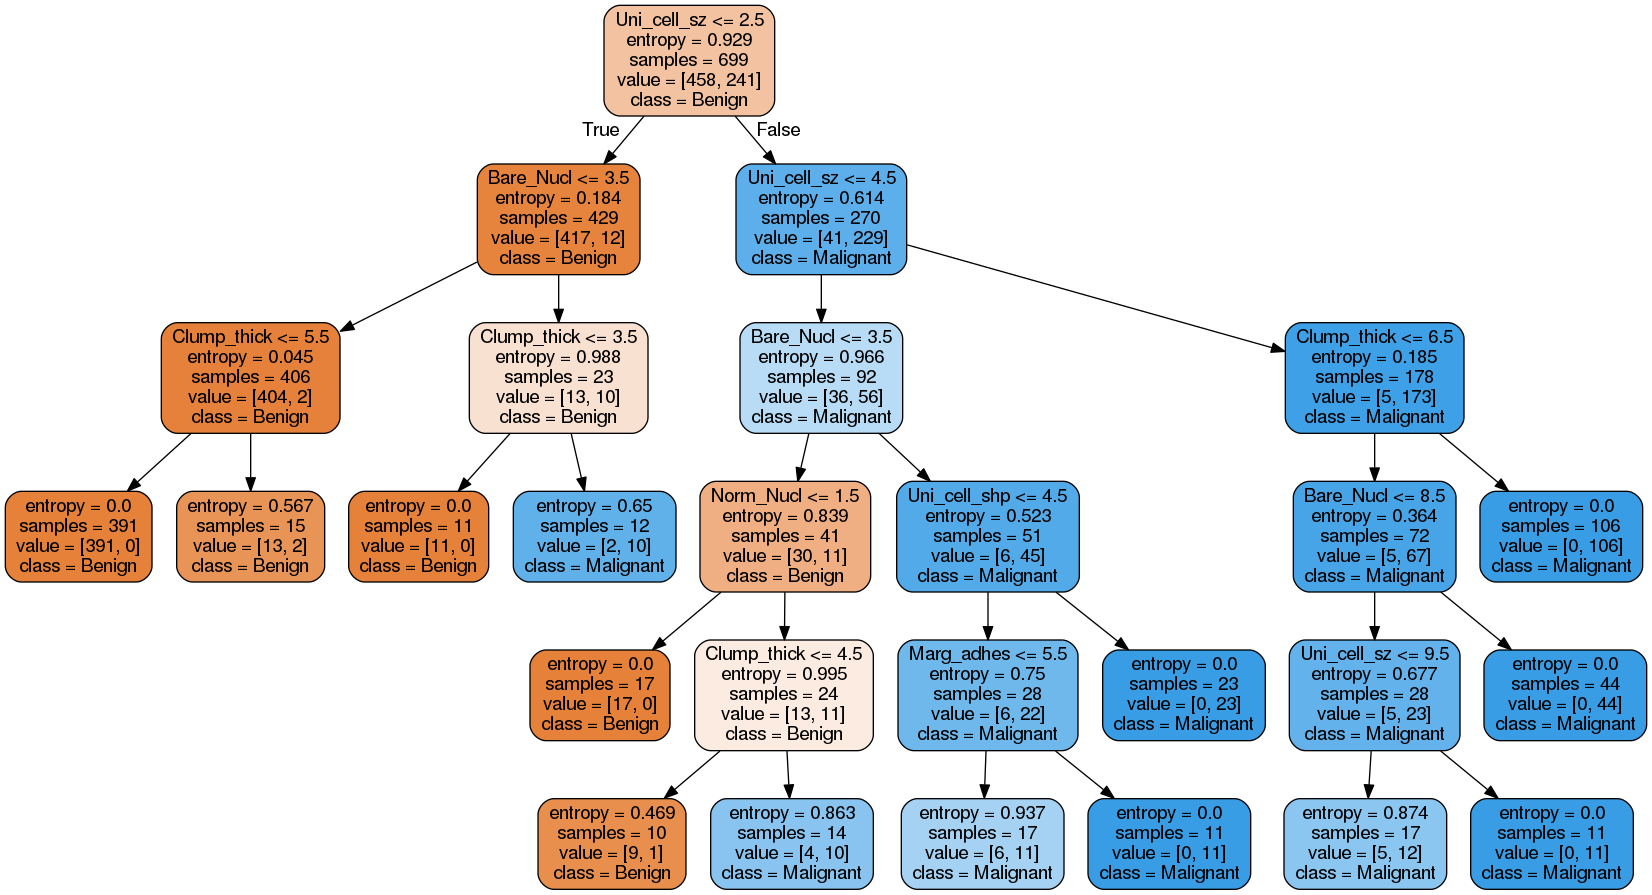

In [16]:
# Show the decision trees
# First, the gini tree
display(Markdown('### Best Gini Tree'))
tree.export_graphviz(gini_gs.best_estimator_, out_file='KenjiOman-L04-best_Gini.dot', filled=True, rounded=True, feature_names=df.drop(columns='Class').columns,
                     class_names=['Benign', 'Malignant'])
os.system("dot -Tpng KenjiOman-L04-best_Gini.dot -o KenjiOman-L04-best_Gini.png")
display(Image('KenjiOman-L04-best_Gini.png'))
# Then, the best entropy tree
display(Markdown('### Best Entropy Tree'))
tree.export_graphviz(entropy_gs.best_estimator_, out_file='KenjiOman-L04-best_Entropy.dot', filled=True, rounded=True, feature_names=df.drop(columns='Class').columns,
                     class_names=['Benign', 'Malignant'])
os.system("dot -Tpng KenjiOman-L04-best_Entropy.dot -o KenjiOman-L04-best_Entropy.png")
Image('KenjiOman-L04-best_Entropy.png')

As we see above, both models used Uniformity of Cell Size as the number one feature to split on, with Bare Nuclei within the next layer.  However, the splitting criterion used for Bare Nuclei is different (<= 3.5 vs <= 4.5), and the subsequent features are different.

Both models likely pick Cell Size as the first feature (the same feature) because it truly has the best discriminating power, meaning, it is likely highly correlated with the target variable (as the Uniformity of Cell Size goes up, so does the likelihood of the cells being malignant).  However, after that, the two models select different features to split on because their impurity measure (Gini vs Entropy criterion) is different.

## AUC, precision, and recall of best model
In our [work above](#Best-Entropy-Hyperparameters-and-Metrics), we found that the best AUC we could achieve was for a model that used the entropy criterion, with max_depth = 6 (basically, no constraint on depth), min_samples_leaf = 10, and min_samples_split =  22.  For this model, we achieve a precision of 0.91 and a recall of 0.88.  Which is a better metric?

Precision is defined as the number of true positives, out of those things predicted to be positive (how likely are we to be right, when we claim a sample is malignant), compared to recall (sensitivity) being the number of true positives out of things that were actually positive (what fraction of malignant samples were correctly identified?).  Which metric we use depends on the specific use case.

Optimizing precision means, if our test identifies something as malignant, we can be very confident that it is really so (high credibility in positive results).  However, such an optimization can in part be achieved by just being very conservative in what we call malignant (only the absolutely most obvious of samples), and as a result, we will miss the vast majority of things that are actually malignant.  If we optimize for recall, we try to make sure we capture as many samples that are malignant as possible, but this can be achieved by being very generous with our labeling of things as malignant, leading to many samples being called malignant that are actually not (overdiagnosis).  The limit of optimizing for recall is to call everything as malignant always -- we will have 100% recall, but have _many_ false positives, which decreases the credibility of the test.

So, we are balancing two competing needs -- the credibility of a positive result and the desire to capture as many malignant samples as possible.  Ideally, if we have a separate, independent measure of malignancy, we could set our recall slightly higher (be somewhat more promiscuous in calling things as malignant), and rely on the second test to more strictly validate malignancy.  And, if all else fails, close supervision of patients with inconclusive test results will allow conclusive results to be drawn in the future, as malignant cells by definition are active, and will quickly make themselves known.

## Implications of Model
What are the implications of this type of machine learning algorithm for breast cancer analysis?  If the best model (balancing precision and recall, as discussed above) can be found, the decision tree is highly interpretable.  Thus, a physician (or perhaps even a technician) in the clinic can follow the rules prescribed by the decision tree to make calls of benign or malignant.